# Step1: 入口格式化
- csv必须包含'评论内容', '评论时间', '评分' 三列

In [7]:
import pandas as pd
from modules.utils import csv_enter


x = csv_enter('./buffer/amz_bsr_reviews_points.csv')


Index(['Unnamed: 0', 'ASIN', '标题', '标题(翻译)', '评论内容', '内容(翻译)', 'VP评论',
       'Vine Voice评论', '型号', '评分', '赞同数', '图片数量', '图片地址', '是否有视频', '视频地址',
       '评论链接', '评论人', '头像地址', '所属国家', '评论人主页', '红人计划链接', '评论时间', '体验点分析',
       '体验点', '分析结果'],
      dtype='object')
Before Time filtering:
(799, 25)
After Time filtering:
(772, 25)


# Step2: 体验点挖掘
- 体验点的examples

In [ ]:
import yaml
from modules.agent import OpenAICommentAnalysisAgent


with open('openai_keys.yaml', 'r') as f:
    data = yaml.safe_load(f)

agent = OpenAICommentAnalysisAgent(openai_key=data['openai']['key'], criteria='stations', model='gpt-4o-2024-08-06', template='desk')
print(agent.get_points_extract_prompt('desk'))


You are a review analyst. You task is to extract customers' experience points from customer reviews. These are all reviews for a product. The answer format should be {'point1': 'simple description of what reviewer talked', ...}.
- When categorizing user feedback on experience points, the definitions should be as specific and informative as possible. For example, a comment like "This table is good" is too vague and lacks specific information. In contrast, "This table looks good" provides a clear point, indicating the table's aesthetic appeal. Therefore, clear definitions can help us better understand the users' actual experiences.
Example1: comment="Wonderful desk! Wonderful people to work with. Thank you"; output={}
Example2: comment="It's a great looking product once it is all put together. There are a lot of screws, so be careful when screwing the frame to the desk top panels to prevent screws penetrating through the panels. Double check the screw sizes."; output={'Aesthetics': 'grea

In [ ]:
import re
import yaml
import pandas as pd
from tqdm import tqdm
from modules.agent import OpenAICommentAnalysisAgent



def extract_output(text):
    pattern = r'\{.*?\}'
    matches = re.findall(pattern, text, re.DOTALL)

    matches = [match.replace('\n', '') for match in matches]
    return matches


df = pd.read_csv('./docs/testset_stations_bs_reviews.csv', sep=None, engine='python')
print(df.columns)
print(df.shape)

with open('openai_keys.yaml', 'r') as f:
    data = yaml.safe_load(f)

agent = OpenAICommentAnalysisAgent(openai_key=data['openai']['key'], criteria='stations', model='gpt-4o-2024-08-06', template='desk')

for i in tqdm(range(len(df))):
    comment = df.iloc[i]['content']
    if not isinstance(comment, str):
        continue
    
    
    points = agent.points_extract(comment)
    # print(points)
    df.loc[i, '体验点分析'] = points
    extract_points = extract_output(points)
    df.loc[i, '体验点'] = ''.join(extract_points)
    # print(extract_points[0])
    # break

df.to_csv('./results/stations_bs_reviews_points.csv', sep='\t')

# Step3: 聚类&主题分析

In [31]:
import pandas as pd 

df = pd.read_csv('./buffer/amz_bsr_reviews_points.csv', sep=None, engine='python')
print(df.columns)
exp_dict = df['体验点'].dropna().tolist()  # 删除空值并转为列表
exp_points = []
exp_desc = []
for i in range(len(exp_dict)):
    exp = eval(exp_dict[i])
    for point, des in exp.items():
        exp_desc.append(des)
        exp_points.append(point)

print(exp_points)
print(exp_desc)

Index(['Unnamed: 0', 'ASIN', '标题', '标题(翻译)', '评论内容', '内容(翻译)', 'VP评论',
       'Vine Voice评论', '型号', '评分', '赞同数', '图片数量', '图片地址', '是否有视频', '视频地址',
       '评论链接', '评论人', '头像地址', '所属国家', '评论人主页', '红人计划链接', '评论时间', '体验点分析',
       '体验点', '分析结果'],
      dtype='object')
['Build Quality', 'Fit', 'Assembly Difficulty', 'Instructions Clarity', 'Missing Assembly Instructions', 'Aesthetics', 'Quality', 'Ease of Assembly', 'Clarity of Instructions', 'Assembly Process', 'Build Quality', 'Build Quality', 'Drawer Functionality', 'Material Quality', 'Surface Maintenance', 'Keyboard Tray Compatibility', 'Aesthetics', 'Sturdiness', 'Assembly Instructions', 'Assembly Time', 'Manufacturer Support', 'Functionality', 'Size', 'Color', 'Storage', 'Overall Satisfaction', 'Size', 'Aesthetics', 'Material Quality', 'Aesthetics', 'Functionality', 'Sturdiness', 'Assembly Time', 'Customer Service', 'Aesthetics', 'Quality for Price', 'Missing Parts', 'Customer Service', 'Assembly Time', 'Assembly Instructions', 'Asse

In [32]:
from FlagEmbedding import BGEM3FlagModel

model = BGEM3FlagModel('/home/tom/codes/models/bge-m3',  
                       use_fp16=True) # Setting use_fp16 to True speeds up computation with a slight performance degradation
embeddings = model.encode(exp_desc, batch_size=12, max_length=1024)['dense_vecs']

pre tokenize: 100%|██████████| 257/257 [00:00<00:00, 3735.89it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 257/257 [00:02<00:00, 109.02it/s]


In [23]:
# ========== kmeans 1 ==========
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score


# Elbow method to find the optimal number of clusters
inertia = []
K = range(1, 20)
for k in K:
    km = KMeans(n_clusters=k, init='k-means++', n_init=10)
    km.fit(embeddings)
    inertia.append(km.inertia_)

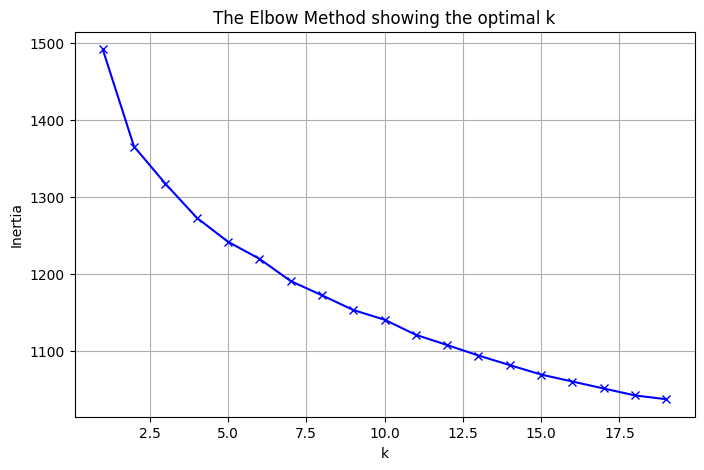

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.grid()
plt.show()

In [26]:
# ========== kmeans 2 ==========
num_clusters = 100
km = KMeans(n_clusters=num_clusters)
km.fit(embeddings)


#量化聚类效果
print("Inertia（越小越好）:", km.inertia_) #均方误差 (Inertia, SSE)

clusters = km.fit_predict(embeddings)  # 获取每个数据点的簇编号
silhouette_avg = silhouette_score(embeddings, clusters) #轮廓系数 (Silhouette Score)
print(f"Silhouette Score（越接近1越好）: {silhouette_avg:.4f}")

ch_score = calinski_harabasz_score(embeddings, clusters)  # CH 指数 (Calinski-Harabasz Index)
print(f"Calinski-Harabasz Index（越大越好）: {ch_score:.4f}")

db_score = davies_bouldin_score(embeddings, clusters)  # DB 指数 (Davies-Bouldin Index)
print(f"Davies-Bouldin Index（越小越好）: {db_score:.4f}")

Inertia（越小越好）: 809.6863798124275
Silhouette Score（越接近1越好）: 0.0806
Calinski-Harabasz Index（越大越好）: nan
Davies-Bouldin Index（越小越好）: 2.7357


/home/tom/miniconda3/envs/commana/lib/python3.11/site-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: overflow encountered in scalar multiply
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))
/home/tom/miniconda3/envs/commana/lib/python3.11/site-packages/sklearn/metrics/cluster/_unsupervised.py:386: RuntimeWarning: invalid value encountered in scalar divide
  else extra_disp * (n_samples - n_labels) / (intra_disp * (n_labels - 1.0))


In [ ]:
# ========== TF-IDF主题词提取 ==========
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


df = pd.DataFrame(columns=['簇编号', '簇大小', '体验描述', '体验点', '主题词'])

# 获取聚类标签并整理各簇文本
clusters = km.labels_.tolist()
cluster_texts = {i: [] for i in range(num_clusters)}
cluster_points = {i: [] for i in range(num_clusters)}
for idx, label in enumerate(clusters):
    cluster_texts[label].append(exp_desc[idx])
    cluster_points[label].append(exp_points[idx])

# 将每个簇的搜索词合并为一个"文档"
cluster_documents = []
for cluster_id in range(num_clusters):
    # 将簇内所有搜索词用空格连接，保留原始短语结构
    cluster_doc = " ".join(cluster_texts[cluster_id])
    cluster_documents.append(cluster_doc)

# 全局TF-IDF计算
tfidf_vectorizer = TfidfVectorizer(
    #stop_words=stop_words,
    ngram_range=(1, 3),  # 保持短语检测能力
    max_df=0.85,         # 过滤出现在85%以上簇中的常见词
    min_df=1             # 允许出现1次的词（小簇需要）
)
tfidf_matrix = tfidf_vectorizer.fit_transform(cluster_documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

# 为每个簇提取主题词
for cluster_id in range(num_clusters):
    try:
        # 获取当前簇的TF-IDF向量
        cluster_tfidf = tfidf_matrix[cluster_id].toarray().flatten()
        
        # 按TF-IDF值降序排序
        sorted_indices = np.argsort(cluster_tfidf)[::-1]
        
        # 提取前10个候选词
        top_candidates = [feature_names[i] for i in sorted_indices[:10]]
        
        # 验证候选词是否实际存在于原始搜索词中
        valid_keywords = []
        original_terms = " ".join(cluster_texts[cluster_id]).lower()
        for candidate in top_candidates:
            # 检查候选词是否作为完整短语或单词存在于原始搜索词
            if any(
                candidate.lower() == term.lower() or 
                candidate.lower() in term.lower().split()
                for term in cluster_texts[cluster_id]
            ):
                valid_keywords.append(candidate)
        
        # 最终取前5个有效词
        final_keywords = valid_keywords[:5]
        
        # 打印结果
        print(f"\nCluster {cluster_id}（包含{len(cluster_texts[cluster_id])}个体验描述）")
        print("代表性体验描述:", ", ".join(cluster_texts[cluster_id][:5]) + "...")
        print("代表性体验点:", ", ".join(cluster_points[cluster_id][:5]) + "...")
        print("TF-IDF主题词:", ", ".join(final_keywords))
        print("─" * 80)
        # 将结果存入DataFrame
        df.loc[len(df), '簇编号'] = cluster_id
        df.loc[len(df)-1, '簇大小'] = len(cluster_texts[cluster_id])
        df.loc[len(df)-1, '体验描述'] = ", ".join(cluster_texts[cluster_id]) + "..."
        df.loc[len(df)-1, '体验点'] = ", ".join(cluster_points[cluster_id]) + "..."
        df.loc[len(df)-1, '主题词'] = ", ".join(final_keywords)
    except Exception as e:
        print(f"处理簇 {cluster_id} 时发生错误: {str(e)}")

df.to_csv('./buffer/tmp.csv', sep='\t', index=False)

# Step4: 体验点交付格式化

In [ ]:
{'stations': {'Installation Difficulty': 'The user found the product installation either difficult or easy.',
 'Installation Time': 'The installation took an unreasonably long time, and the user perceived it as too long. There is a distinction between an objective duration declare and a complaint.',
 'Number of Assembly Parts': 'The user felt there were too many parts to assemble.',
 'Manual Content': 'The instruction manual is comprehensive, easy to understand, and accurate.',
 'Package Integrity': 'The package was intact upon arrival. Damage to internal parts does not imply poor packaging.',
 'Damage upon arrival': 'Some parts of the product itself were damaged upon arrival, or some components were broken.',
 'Missing or Wrong Parts': 'Some items were missing or incorrect in the received product.',
 'Shipping Speed': 'The user received the product within a certain timeframe.',
 'Customer Service Quality': 'The user had a specific experience with customer service when encountering issues after receiving the product.',
 'After-sales return and exchange service': 'The user had a particular experience and incurred costs when requesting a return or exchange due to issues.',
 'Screw Hole Alignment': 'The screws and holes aligned properly or did not align during installation.',
 'Drawer Slide Smoothness': 'The drawer operates smoothly.',
 'Cabinet Door Smoothness': 'The cabinet door opens and closes smoothly.',
 'Noise During Use': 'The product produces noise during use.',
 'Panel Alignment': 'If the table consists of multiple panels, they are properly aligned or misaligned after assembly.',
 'Component quality': 'Some parts are easily damaged during installation or use.',
 'Tabletop Quality': 'The tabletop quality is defined by its material, thickness, hardness, water resistance, and edge finishing.',
 'Table leg quality': 'The table leg quality is defined by its material, slip resistance, and sturdiness.',
 'Stability': 'The table is stable and does not wobble.',
 'Odor': 'The product has or does not have an unpleasant odor.',
 'Ease of Cleaning': 'The table is easy to clean during use.',
 'Stain Resistance': 'The table resists stains over time.',
 'Aesthetics': 'The table is visually appealing, stylish, and elegant.',
 'Color': 'The table has a specific color.',
 'Legroom Space': 'The legroom is spacious enough and does not feel cramped.',
 'Storage Space': 'The user has enough storage space for their items. Desk surface space is not considered storage; only drawers and shelves qualify.',
 'Additional power outlet': 'The product includes power outlets, Type-C ports, USB ports, or similar features.',
 'Cable Management': 'The product has cable management features such as cable holes, organizers, or trays.'}
}

# Step5: 体验点和情感偏向提取可插拔化工程

In [ ]:
import os
import re
import yaml
import time
import argparse
import pandas as pd
from tqdm import tqdm

from modules.agent import OpenAICommentAnalysisAgent, API2DCommentAnalysisAgent

def extract_output(text):
    pattern = r'\{.*?\}'
    matches = re.findall(pattern, text, re.DOTALL)

    matches = [match.replace('\n', '') for match in matches]
    return matches


def remove_duplicate_values(input_dict):
    seen_values = set()  # 用于存储已经出现过的值
    output_dict = {}  # 用于存储最终的结果

    for key, value in input_dict.items():
        if value not in seen_values:
            seen_values.add(value)
            output_dict[key] = value

    return output_dict



def infer(comment_analyzor, dataframe, save_path):
    df = dataframe

    if not os.path.exists(save_path):
        dataframe.iloc[:0].to_csv(save_path, sep='\t', index=False)
    df_to_save = pd.read_csv(save_path, sep='\t')
    start_index = len(df_to_save)

    length = len(dataframe)
    assert length > start_index, 'The save file length is more than dataframe to do comment analysis'

    for i in tqdm(range(start_index, length)):
        comment = df.iloc[i]['内容']
        if not isinstance(comment, str):
            continue
        
        row = dataframe.iloc[[i]].copy()
        row.loc[i, '英文评论'] = comment

        # 分析评论
        analysis = comment_analyzor.comment_analyze(comment)
        row.loc[i, '英文分析'] = analysis
        #print(f"分析结果: {analysis}")

        # 提取结果
        extracted_output = extract_output(analysis)
        extracted_output = ''.join(extracted_output)
        extracted_output = eval(extracted_output)
        extracted_output = remove_duplicate_values(extracted_output)
        row.loc[i, '分析结果'] = str(extracted_output)
        #print(f"提取结果: {extracted_output}")

        # 翻译评论
        # translated_comment = comment_analyzor.translate(comment)
        # row.loc[i, '中文评论'] = translated_comment
        #print(f"原: {comment}\n翻译评论: {translated_comment}")

        # 翻译分析
        # translated_analysis = comment_analyzor.translate(analysis)
        # row.loc[i, '中文分析'] = translated_analysis
        #print(f"翻译分析: {translated_analysis}")

        # 反审查
        # check_result = 
        row.to_csv(save_path, sep='\t', mode='a', header=False, index=False)

with open(api_key_yaml_path, "r", encoding="utf-8") as file:
    data = yaml.safe_load(file)
my_key = data[arch]['key']
comment_analyzor = OpenAICommentAnalysisAgent(openai_key=my_key, criteria=criteria, model=model, template=template)




# Step6: 数据分析

In [28]:
import pandas as pd
import json
import numpy as np
from collections import defaultdict
import ast


df = pd.read_csv("./buffer/test_for_da.csv", sep=None, engine='python')
print(df.columns)


def cal_importance(df):
    """
    计算DataFrame中'分析结果'列的值的出现频率。

    参数：
    df (pandas.DataFrame): 包含'评分'和'分析结果'列的DataFrame。

    返回：
    dict: 每个值的出现频率，格式为{值: 频率}。
    """
    
    # 使用defaultdict来简化计数
    value_counts = defaultdict(int)
    total_comments = 0
    
    # 遍历'分析结果'列
    for analysis in df['分析结果']:
        # 将字符串转换为字典，使用json.loads
        try:
            # 将单引号替换为双引号以符合JSON格式
            analysis_dict = json.loads(analysis.replace("'", "\""))
        except json.JSONDecodeError:
            # 忽略无法解析的JSON字符串
            print('-')
            continue
        
        # 增加评论计数
        total_comments += 1
        
        # 提取值并更新计数
        for value in analysis_dict.values():
            value_counts[value] += 1
    
    # 计算频率
    if total_comments > 0:
        frequency = {k: v / total_comments for k, v in value_counts.items()}
    else:
        frequency = {}
    
    return frequency




def cal_satisfaction(df):
    "表头命名规则：'评分', '分析结果'，输出每个出现的体验点的满意度"
    
    df['分析结果'] = df['分析结果'].apply(ast.literal_eval)
    
    # 初始化满意度的字典
    satisfaction = {}
    for index, row in df.iterrows():
        analysis_result = row['分析结果']
        score = row['评分']
        
        for key in analysis_result.keys():
            value = analysis_result[key]
            key = key.lower()
            if key.startswith('pos'):
                if value in satisfaction:
                    satisfaction[value].append(score)
                else:
                    satisfaction[value] = [score]
            elif key.startswith('neg'):
                if value in satisfaction:
                    satisfaction[value].append(score - 6)
                else:
                    satisfaction[value] = [score - 6]
    
    # 计算满意度和分歧度
    satisfaction_result = {}
    diversity_result = {}
    print(satisfaction)
    
    for key, scores in satisfaction.items():
        mean_score = np.mean(scores)
        if len(scores) > 1:
            std_dev = np.std(scores, ddof=1)
        else:
            std_dev = 0
        satisfaction_result[key] = mean_score
        diversity_result[key] = std_dev
    
    return satisfaction_result, diversity_result


importance = cal_importance(df)
satisfaction, diversity = cal_satisfaction(df)
print("重要性：", importance)
print("满意度：", satisfaction)
print("分歧度：", diversity)


Index(['﻿url', 'author', '评分', 'date', 'title', 'content', 'location',
       'images[0]', 'images[1]', 'images[2]', 'images[3]', '内容', '英文评论',
       '中文评论', '英文分析', '中文分析', '分析结果', '反审查结果'],
      dtype='object')
{'Cable Management': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, -1, 5, 5, 5, 5, 5, 5, 5, -1, 5, 5, -1, -1, 5, -1, -2, -2, -2, -2, -2, -2, -2], 'Aesthetics': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

# Step7: 可视化

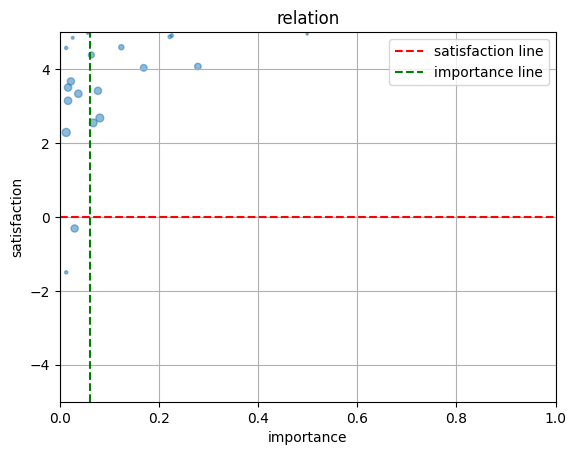

In [29]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.family'] = 'DejaVu Sans'


# 计算重要度的均值
importance_mean = np.mean(list(importance.values()))

# 提取数据
importance_values = list(importance.values())
satisfaction_values = list(satisfaction.values())
divergence_values = list(diversity.values())
divergence_values = [x * 10 for x in divergence_values]  # 将分歧度乘以100以便于可视化

# 绘制散点图
plt.scatter(importance_values, satisfaction_values, s=divergence_values, alpha=0.5)

# 绘制参照线
plt.axhline(y=0, color='r', linestyle='--', label='satisfaction line')
plt.axvline(x=importance_mean, color='g', linestyle='--', label='importance line')

# 添加标签和标题
plt.xlabel('importance')
plt.ylabel('satisfaction')
plt.title('relation')
plt.ylim(-5, 5)
plt.xlim(0, 1)

# 显示图例
plt.legend()
plt.grid()
# 显示图形
plt.show()


In [1]:
96-71

25